In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [2]:
root = 'data/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
weather_train_df["timestamp"] = pd.to_datetime(weather_train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

# test_df = pd.read_csv(root + 'test.csv')
# test_df["hour"] = pd.to_datetime(test_df["timestamp"], format='%Y-%m-%d %H:%M:%S').dt.hour

# weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
# sample_submission = pd.read_csv(root + 'sample_submission.csv')

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_df = reduce_mem_usage(train_df)
weather_train_df = reduce_mem_usage(weather_train_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [5]:
train_df.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype=object)

In [6]:
building_meta_df.columns.values

array(['site_id', 'building_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count'], dtype=object)

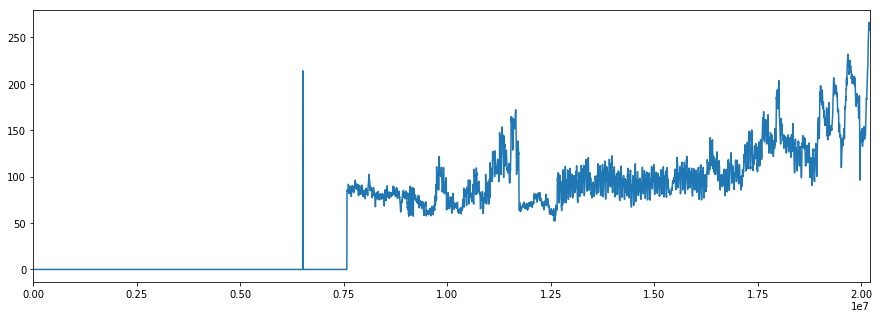

In [7]:
plt.figure(figsize = (15,5))
train_df.query('building_id==6 and meter==0')['meter_reading'].plot()
plt.show()

In [8]:
len(train_df)

20216100

In [9]:
# let us remove records with zero values
train_df = train_df[train_df['meter_reading'] != 0]


In [10]:
len(train_df)

18342124

In [113]:
# select only rows with meter 0
single_meter = train_df[train_df['meter']==0]

len(single_meter)

11530741

In [114]:
sampled = single_meter.sample(frac=1)
N = int(len(sampled)/2)
print(N)

5765370


In [115]:
train = sampled.head(N)
test = sampled.tail(N)
train.head()

,building_id,meter,timestamp,meter_reading
4102674,467,0,2016-03-18 20:00:00,113.660004
13349528,310,0,2016-08-31 20:00:00,39.270000
19453658,1435,0,2016-12-18 12:00:00,6.725000
268799,1406,0,2016-01-05 20:00:00,65.175003
8331440,257,0,2016-06-03 04:00:00,45.150002


In [57]:
len(train)

1180876

In [ ]:
weather_train_df.columns.values

In [ ]:
# Let us check missing values in building_meta_df 
building_meta_df.isnull().sum()

In [ ]:
bld_meta = building_meta_df.dropna()
weather_train_df = weather_train_df.dropna(subset=['air_temperature'])

In [116]:
bld_meters = pd.merge(train, building_meta_df, on='building_id')
# bld_met_weath = pd.merge(bld_meters, weather_train_df, on=['timestamp', 'site_id'])
bld_meters.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,467,0,2016-03-18 20:00:00,113.660004,3,Public services,47439,NaN,NaN
1,467,0,2016-11-17 01:00:00,116.730003,3,Public services,47439,NaN,NaN
2,467,0,2016-06-15 11:00:00,179.309998,3,Public services,47439,NaN,NaN
3,467,0,2016-03-13 22:00:00,111.949997,3,Public services,47439,NaN,NaN
4,467,0,2016-06-03 02:00:00,163.679993,3,Public services,47439,NaN,NaN


In [33]:
set(bld_meters['primary_use'])

{'Education',
 'Entertainment/public assembly',
 'Food sales and service',
 'Healthcare',
 'Lodging/residential',
 'Manufacturing/industrial',
 'Office',
 'Other',
 'Parking',
 'Public services',
 'Religious worship',
 'Retail',
 'Services',
 'Technology/science',
 'Utility',
 'Warehouse/storage'}

In [ ]:
building_meta_df[['site_id', 'primary_use']].groupby('primary_use').count()

In [34]:
one_use = bld_meters[bld_meters['primary_use']] =='Entertainment/public assembly']
len(one_use)

364107

In [ ]:
one_use['weekday'] = one_use['timestamp'].dt.dayofweek
one_use.tail()

In [82]:
one_use = bld_meters

In [38]:
one_use.corr()

### it looks like for 0-meter and Education use there are two main variables:
- squre_feet 63%
- floor_count 44%

the third var is 'year_built' which gives 17% of correlation


In [ ]:
# Now we have two smaller datasets to try and test different hypothesis

In [ ]:
# let us explore if dayweek or working hours impact energy consumption

In [ ]:
def loss(y_y1):
    L = sum( (np.log(1+y)-np.log(1+y1))**2 for y, y1 in y_y1)
    return np.sqrt(L / len(y_y1))

In [117]:
X = one_use['square_feet'].values
y = one_use['meter_reading'].values
# reg = LinearRegression().fit(X, y)

In [28]:
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
regr.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [29]:
regr.score(X,y)

0.5909397929910968

In [84]:
lin_reg = LinearRegression().fit(X, y)

In [85]:
lin_reg.score(X,y), lin_reg.coef_, lin_reg.intercept_

(0.01992369342408984, array([0.00394654]), 60.83915255277799)

In [ ]:
NameOfType = 'Healthcare'
building_meta_df[building_meta_df.primary_use == NameOfType]['year_built'].hist()
len(building_meta_df[building_meta_df.primary_use == NameOfType])


# steps

1. imputation of 'year_built'. There are 675 out of 1500 records
2. imputation of 'floor_count'. There are 355 records. floor_count may depend on 'square_feet' and 'primary_use'


In [99]:
test_df = pd.read_csv(root + 'test.csv')
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 596.49 Mb (53.1% reduction)


In [100]:
test_meters = pd.merge(test_df, building_meta_df, on='building_id')
test_meters.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN
1,129,0,0,2017-01-01 01:00:00,0,Education,7432,2008.0,NaN
2,258,0,0,2017-01-01 02:00:00,0,Education,7432,2008.0,NaN
3,387,0,0,2017-01-01 03:00:00,0,Education,7432,2008.0,NaN
4,516,0,0,2017-01-01 04:00:00,0,Education,7432,2008.0,NaN


In [105]:
test_meters = test_meters.sort_values(by=['row_id'])

In [106]:
coeffs = [(1.96e-3, -2.9), (3.33e-3, 313), (176e-3, -9008), (3.94e-3, 61)]

In [107]:
te = test_meters.drop( columns=['timestamp','site_id', 'primary_use', 'year_built', 'floor_count'])

In [108]:
te.head()

,row_id,building_id,meter,square_feet
0,0,0,0,7432
17520,1,1,0,2720
35040,2,2,0,5376
52560,3,3,0,23685
70080,4,4,0,116607


In [109]:
te['building_id'] = 0
for i in range(len(te)):
    if i %1000000 == 0: print(i)
    
    met = te.at[i, 'meter']
    if met == 0:
        te.at[i, 'building_id'] = te.at[i, 'square_feet'] * coeffs[met][0] + coeffs[met][1]
    
    

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000


In [110]:
te.head()

,row_id,building_id,meter,square_feet
0,0,11,0,7432
17520,1,2,0,2720
35040,2,7,0,5376
52560,3,43,0,23685
70080,4,225,0,116607


In [111]:
te = te.rename(columns={'building_id': 'meter_reading'})
te = te.drop(columns=['meter', 'square_feet'])
te.head()

,row_id,meter_reading
0,0,11
17520,1,2
35040,2,7
52560,3,43
70080,4,225


In [112]:
te.to_csv("submission4.csv", index=False)

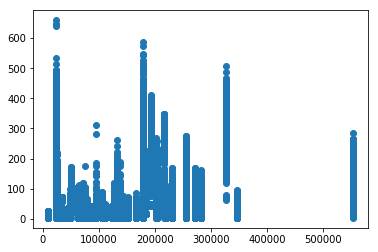

In [124]:
plt.scatter(X,y)
plt.show()

In [123]:
one_site = one_use[one_use.site_id == 2]
X = one_site['square_feet'].values
y = one_site['meter_reading'].values

In [122]:
len(one_site)

33227